In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [12]:
# EULER INTEGRATION FUNCTIONS:

# LINEAR CROSS INHIBITION
def fs_evo_eq(fs,pis,qs,l,lci):
    dfsdt = [0.0,]
    for i in range(len(fs)-1):
        site_i = i+1
        dfdt = fs[0]*((1-l)*pis[i]+l*fs[site_i]) - fs[site_i]/qs[i] #- lci*fs[site_i]*(sum(fs[1:site_i])+sum(fs[site_i+1:]))
        for j in range(len(fs)-1):
            site_j = j+1
            if site_j != site_i:
                dfdt += -lci*fs[site_i]*fs[site_j]
        dfsdt.append(dfdt)
    dfsdt[0] = -1*sum(dfsdt[1:])
    return dfsdt

def ci1(x, thresh):
    ci = 1.0 if x >= thresh else 0.0
    return ci

def ci2(x,x0=0.5,a=10,supLin=False):
    expval = np.exp(-a*(x-x0))
    ci2 = 1/(1+expval)
    if supLin:
        return min(x, ci2)
    else:
        return ci2

def ci3(x,x0=0.5,a=5):
    expval = np.exp(-a*(x-x0))
    return 2*x/(1+expval)

# STEP FUNCTION CROSS INHIBITION (CI1)
def fs_evo_eq_ci1(fs,pis,qs,l,cithresh):
    dfsdt = [0.0,]
    for i in range(len(fs)-1):
        site_i = i+1
        others_com = sum(fs[1:site_i])+sum(fs[site_i+1:])
        dfdt = fs[0]*((1-l)*pis[i]+l*fs[site_i]) - fs[site_i]/qs[i] - fs[site_i]*ci1(others_com,cithresh) *others_com
        dfsdt.append(dfdt)
    dfsdt[0] = -1*sum(dfsdt[1:])
    return dfsdt

# SIGMOID 1 FUNCTION (CI2)
def fs_evo_eq_ci2(fs,pis,qs,l,lci,ci2_args): # ci2_args={'x0':0.5, 'a':10}
    dfsdt = [0.0,]
    for i in range(len(fs)-1):
        site_i = i+1
        #others_com = sum(fs[1:site_i])+sum(fs[site_i+1:])
        dfdt = fs[0]*((1-l)*pis[i]+l*fs[site_i]) - fs[site_i]/qs[i] #- fs[site_i]*lci*ci2(others_com, *ci2_args)
        for j in range(len(fs)-1):
            site_j = j+1
            if site_j != site_i:
                dfdt += -lci*fs[site_i]*ci2(fs[site_j], *ci2_args)
        dfsdt.append(dfdt)
    dfsdt[0] = -1*sum(dfsdt[1:])
    return dfsdt

def fs_evo_eq_ci3(fs,pis,qs,l,lci,ci3_args): # ci2_args={'x0':0.5, 'a':10}
    dfsdt = [0.0,]
    for i in range(len(fs)-1):
        site_i = i+1
        # others_com = sum(fs[1:site_i])+sum(fs[site_i+1:])
        dfdt = fs[0]*((1-l)*pis[i]+l*fs[site_i]) - fs[site_i]/qs[i] #- fs[site_i]*lci*min(ci3(others_com, *ci3_args),1)
        for j in range(len(fs)-1):
            site_j = j+1
            if site_j != site_i:
                dfdt += -lci*fs[site_i]*ci3(fs[site_j], *ci3_args)
        dfsdt.append(dfdt)
    dfsdt[0] = -1*sum(dfsdt[1:])
    return dfsdt

def fs_evo_eq_ci1_indv(fs,pis,qs,l,cithresh):
    dfsdt = [0.0,]
    Nsites = len(fs)-1
    for i in range(len(fs)-1):
        site_i = i+1
        others = [j for j in range(1,Nsites+1) if j != site_i]
        dfdt = fs[0]*((1-l)*pis[i]+l*fs[site_i]) - fs[site_i]/qs[i]
        for j in others:
            # dfdt -= (1/(Nsites-1))*fs[site_i]*ci1(fs[j],cithresh)
            dfdt -= fs[site_i]*ci1(fs[j],cithresh)*fs[j]
        dfsdt.append(dfdt)
    dfsdt[0] = -1*sum(dfsdt[1:])
    return dfsdt

In [13]:
def sols_from_intEvo(pis, qs, l, lci, fs0, evofunc, ciX_args=(0.5, 5), max_time=2000):
    fs = fs0
    dt = 1
    for _ in range(max_time):
        if evofunc == fs_evo_eq_ci2 or evofunc == fs_evo_eq_ci3:
            dfsdt = evofunc(fs,pis,qs,l,lci,ciX_args)
        else:
            dfsdt = evofunc(fs,pis,qs,l,lci)
        fs = [f+dfdt*dt for f,dfdt in zip(fs,dfsdt)]
    return fs

def get_time_evo_int(pis, qs, l, lci, fs0, max_time=2000):
    fs = fs0
    dt = 1
    fs_evo = [[fs0[0], ], [fs0[1], ], [fs0[2], ]]
    for _ in range(max_time):
        dfsdt = fs_evo_eq(fs,pis,qs,l,lci)
        fs = [f+dfdt*dt for f,dfdt in zip(fs,dfsdt)]
        for k in range(len(fs0)):
            fs_evo[k].append(fs[k])
    return fs_evo

In [8]:
fs0 = [1.0, 0.0, 0.0]
pis, qs, l, lci = [0.1, 0.1], [9.0, 10.0], 0.6, 0.6
start_time = time.time()
for _ in range(100):
    fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7898354530334473 seconds ---


In [98]:
pis, qs, l = [0.1, 0.1], [9.0, 10.0], 0.6
# lci = 0.1
fs0 = [0.2, 0.0, 0.8]
# fs0 = [0.0, 0.0, 1.0]
# fs0 = [1.0, 0.0, 0.0]

lci = 0.0
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq)
print('No cross-inhibition: ', fs)

lci = l
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq)
print('Linear cross-inhibition (eq l): ', fs)

# lci = 0.5 # ci as step function, lci indicates threshold
# fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci1)
# print(fs)

# lci = 0.1
# fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci1_indv)
# print(fs)

ci2_args = (0.5, 1)
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci2, ci2_args, max_time=2000)
print('Step cross-inhibition: ', fs)

ci3_args = (0.5, 100)
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci3, ci3_args, max_time=2000)
print('Step_v2 cross-inhibition: ', fs)

No cross-inhibition:  [0.14930432810757627, 0.27740758400249654, 0.5732880878899271]
Linear cross-inhibition (eq l):  [0.1663634862975053, 0.013215363222767153, 0.8204211504797277]
Step cross-inhibition:  [0.48652782341744294, 0.2205330768649874, 0.2929390997175684]
Step_v2 cross-inhibition:  [0.15435288540478748, 0.009982411651741345, 0.835664702943471]


In [29]:
lci = l
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci2, ci2_args, max_time=100)
print(fs)

[0.14053548797670923, 0.007128518761342963, 0.8523359932619475]


### 3 sites test

In [122]:
pis, qs, l = [0.1, 0.1, 0.1], [8.0, 9.0, 10.0], 0.5
lci = l
fs0 = [1.0, 0.0, 0.0, 0.0]
# fs0 = [0.0, 0.34, 0.33, 0.33]
# fs0 = [0.0, 0.5, 0.25, 0.25]
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq)
print(fs)

# lci = 0.5 # ci as step function, lci indicates threshold
# fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci1)
# print(fs)

ci2_args = (0.3, 40)
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci2, ci2_args, max_time=2000)
print(fs)

[0.22903960551680125, 0.030063314079965375, 0.03125150212326688, 0.7096455782799661]
[0.17752244181952428, 0.016552368314464043, 0.016992481615787217, 0.7889327082502244]


In [22]:
lci = 0.5
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci1, max_time=1)
print(fs)

[0.7666, 0.0816, 0.07590000000000002, 0.07590000000000002]


In [117]:
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci1, max_time=1)
print(fs)

[0.7666, 0.0816, 0.07590000000000002, 0.07590000000000002]


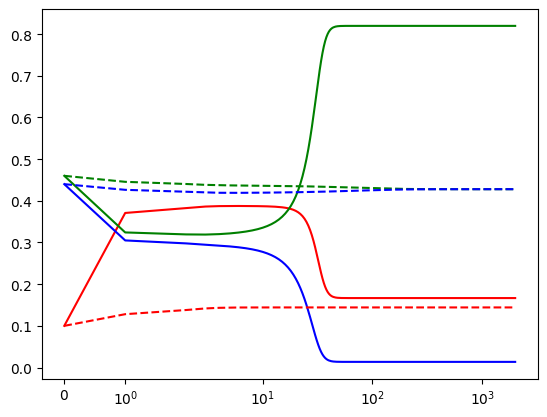

In [33]:
fs0 = [0.1, 0.46, 0.44]

fs_evo = get_time_evo_int(pis, qs, l, lci, fs0)
fig, ax = plt.subplots()
ax.set(xscale='symlog')
iters = list(range(len(fs_evo[0])))
ax.plot(iters, fs_evo[0], color='r')
ax.plot(iters, fs_evo[1], color='g')
ax.plot(iters, fs_evo[2], color='b')

fs_evo = get_time_evo_int(pis, qs, l, 0.0, fs0)
ax.set(xscale='symlog')
iters = list(range(len(fs_evo[0])))
ax.plot(iters, fs_evo[0], color='r', ls='--')
ax.plot(iters, fs_evo[1], color='g', ls='--')
ax.plot(iters, fs_evo[2], color='b', ls='--')


# Solutions for various lambda

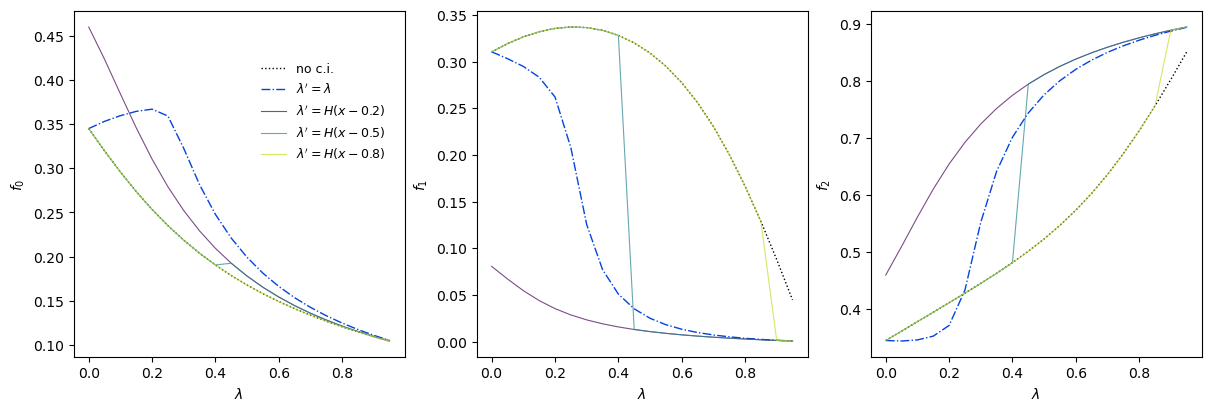

In [8]:
ls = np.arange(0.0, 1.0, 0.05)
pis, qs = [0.1, 0.1], [9.0, 10.0]
fs0 = [1.0, 0.0, 0.0]



fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
for i in range(3):
    ax[i].set(xlabel='$\lambda$', ylabel=f'$f_{i}$')

# no cross inhibition:
fs_evo = [[], [], []]
lci = 0.0
for l in ls:
    fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq)
    for i in range(3):
        fs_evo[i].append(fs[i])
for i in range(3):
    label='no c.i.' if i==0 else '_nolabel_'
    ax[i].plot(ls, fs_evo[i], ls=':', color='k', lw=1.0, label=label)

# cross inhibition = interdependence
fs_evo = [[], [], []]
for l in ls:
    lci = l
    fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq)
    for i in range(3):
        fs_evo[i].append(fs[i])
for i in range(3):
    label=r"$\lambda' = \lambda$" if i==0 else '_nolabel_'
    ax[i].plot(ls, fs_evo[i], ls='-.', color='xkcd:blue', lw=1.0, label=label)

# cross inhibition = step function
lcis = [0.2, 0.5, 0.8]
colors = plt.cm.viridis(np.linspace(0.0,0.9,len(lcis)))
for lci,c in zip(lcis,colors): # threshold of the step function
    fs_evo = [[], [], []]
    for l in ls:
        fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci1)
        for i in range(3):
            fs_evo[i].append(fs[i])
    for i in range(3):
        label=rf"$\lambda' = H(x-{lci})$" if i==0 else '_nolabel_'
        ax[i].plot(ls, fs_evo[i], label=label, lw=0.8, alpha=0.7, color=c)

# each state individually inhibits
# fs_evo = [[], [], []]
# lci = 0.1 # threshold of the step function
# for l in ls:
#     fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci1_indv)
#     for i in range(3):
#         fs_evo[i].append(fs[i])
# for i in range(3):
#     ax[i].plot(ls, fs_evo[i])

ax[0].legend(loc=(0.55,0.55), fontsize=9, frameon=False)

fig.savefig('fs_different_cross_inh.png')

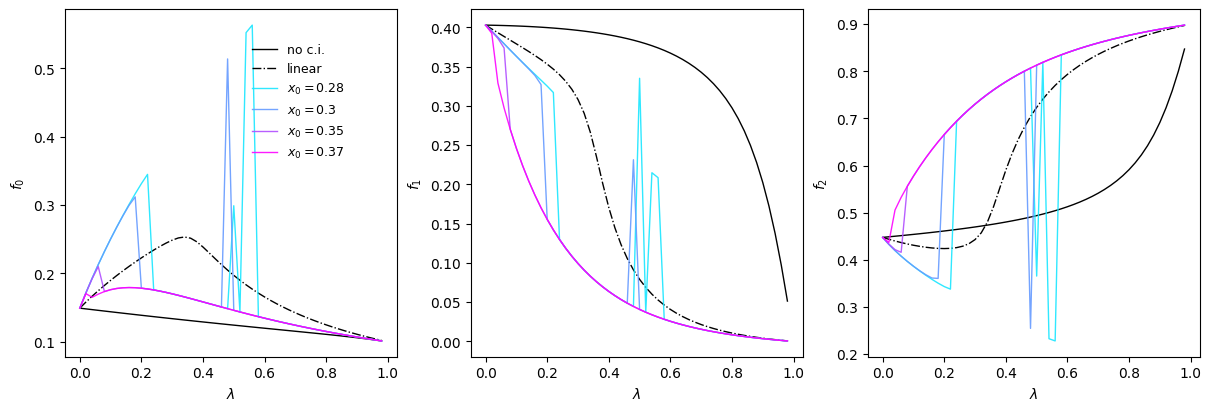

In [10]:
ls = np.arange(0.0, 1.0, 0.02)
pis, qs = [0.3, 0.3], [9.0, 10.0]
fs0 = [1.0, 0.0, 0.0]



fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
for i in range(3):
    ax[i].set(xlabel='$\lambda$', ylabel=f'$f_{i}$')

# no cross inhibition:
fs_evo = [[], [], []]
lci = 0.0
for l in ls:
    fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq)
    for i in range(3):
        fs_evo[i].append(fs[i])
for i in range(3):
    label='no c.i.' if i==0 else '_nolabel_'
    ax[i].plot(ls, fs_evo[i], ls='-', color='k', lw=1.0, label=label)

# cross inhibition = interdependence
fs_evo = [[], [], []]
for l in ls:
    lci = l
    fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq)
    for i in range(3):
        fs_evo[i].append(fs[i])
for i in range(3):
    # label=r"$\lambda' = \lambda$" if i==0 else '_nolabel_'
    label=r"linear" if i==0 else '_nolabel_'
    ax[i].plot(ls, fs_evo[i], ls='-.', color='xkcd:black', lw=1.0, label=label)

# cross inhibition = sigmoid of the inhibiting population
# varying x0:
x0s = [0.2, 0.35, 0.5, 0.8]
# around the "sweet spot":
x0s = [0.28, 0.3, 0.35, 0.37]
a = 100
colors = plt.cm.cool(np.linspace(0.1,0.99,len(x0s)))
for x0,c in zip(x0s,colors): # threshold of the step function
    fs_evo = [[], [], []]
    ci2_args = (x0, a)
    for l in ls:
        lci = l
        fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci2, ci2_args)
        for i in range(3):
            fs_evo[i].append(fs[i])
    for i in range(3):
        label=rf"$x_0 = {x0}$" if i==0 else '_nolabel_'
        ax[i].plot(ls, fs_evo[i], label=label, lw=1.0, alpha=0.9, color=c)

#### varying a instead:
# aparams = [5, 10, 30, 100]
# colors = plt.cm.cool(np.linspace(0.1,0.99,len(aparams)))
# for a,c in zip(aparams,colors): # threshold of the step function
#     fs_evo = [[], [], []]
#     ci2_args = (0.5, a)
#     for l in ls:
#         lci = l
#         fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci2, ci2_args)
#         for i in range(3):
#             fs_evo[i].append(fs[i])
#     for i in range(3):
#         label=rf"$a = {a}$" if i==0 else '_nolabel_'
#         ax[i].plot(ls, fs_evo[i], label=label, lw=1.0, alpha=0.9, color=c)

ax[0].legend(loc=(0.55,0.55), fontsize=9, frameon=False)
# fig.savefig('ci_numerical_int_compare_lin_and_sigmoids_chx0.png')
# fig.savefig('ci_numerical_int_compare_lin_and_sigmoids_cha.png')

### Cross inhibit. when lambda' != lambda

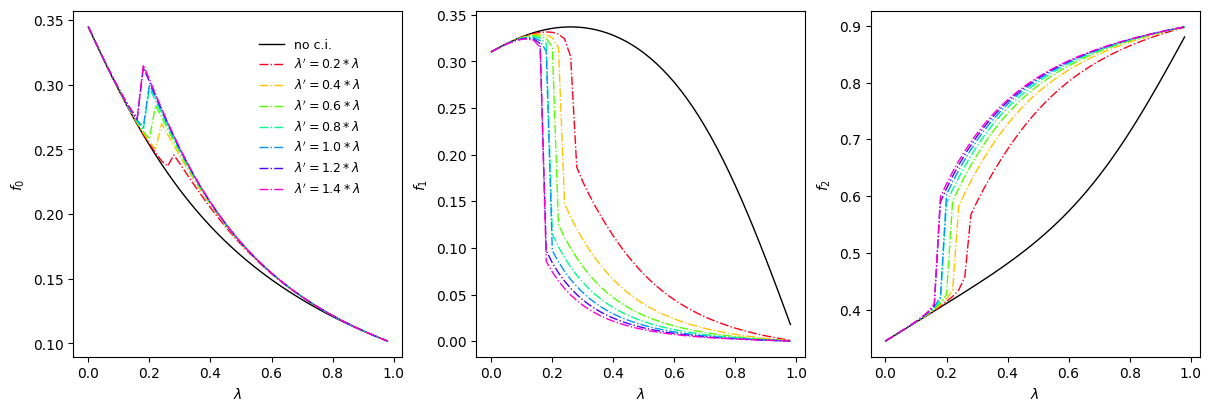

In [14]:
ls = np.arange(0.0, 1.0, 0.02)
pis, qs = [0.1, 0.1], [9.0, 10.0]
fs0 = [1.0, 0.0, 0.0]

fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
for i in range(3):
    ax[i].set(xlabel='$\lambda$', ylabel=f'$f_{i}$')

# no cross inhibition:
fs_evo = [[], [], []]
lci = 0.0
for l in ls:
    fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq)
    for i in range(3):
        fs_evo[i].append(fs[i])
for i in range(3):
    label='no c.i.' if i==0 else '_nolabel_'
    ax[i].plot(ls, fs_evo[i], ls='-', color='k', lw=1.0, label=label)

# lci_factors = [1/4, 1/3, 1/2, 2/3, 3/4, 1]
lci_factors = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
colors = plt.cm.gist_rainbow(np.linspace(0.01, 0.99, len(lci_factors)))


# cross inhibition = interdependence
# for lci_factor,c in zip(lci_factors, colors):
#     fs_evo = [[], [], []]
#     for l in ls:
#         lci = l*lci_factor
#         if lci > 1.0:
#             lci = 1.0
#         fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq)
#         for i in range(3):
#             fs_evo[i].append(fs[i])
#     for i in range(3):
#         label=rf"$\lambda' = {lci_factor}*\lambda$" if i==0 else '_nolabel_'
#         ax[i].plot(ls, fs_evo[i], ls='-.', color=c, lw=1.0, label=label)
# ax[0].legend(loc=(0.55,0.45), fontsize=9, frameon=False)
# fig.savefig('ci_numerical_int_compare_lin_lci_factors.png')


# cross ihibition = sigmoid:
ci2_args = (0.5, 40)
for lci_factor,c in zip(lci_factors, colors):
    fs_evo = [[], [], []]
    for l in ls:
        lci = l*lci_factor
        if lci > 1.0:
            lci = 1.0
        fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci2, ci2_args)
        for i in range(3):
            fs_evo[i].append(fs[i])
    for i in range(3):
        label=rf"$\lambda' = {lci_factor}*\lambda$" if i==0 else '_nolabel_'
        ax[i].plot(ls, fs_evo[i], ls='-.', color=c, lw=1.0, label=label)
ax[0].legend(loc=(0.55,0.45), fontsize=9, frameon=False)
fig.savefig(f'ci_numerical_int_compare_sigmoid_x0_{ci2_args[0]}_a_{ci2_args[1]}_lci_factors.png')

### Plot the cross inhibition functions:

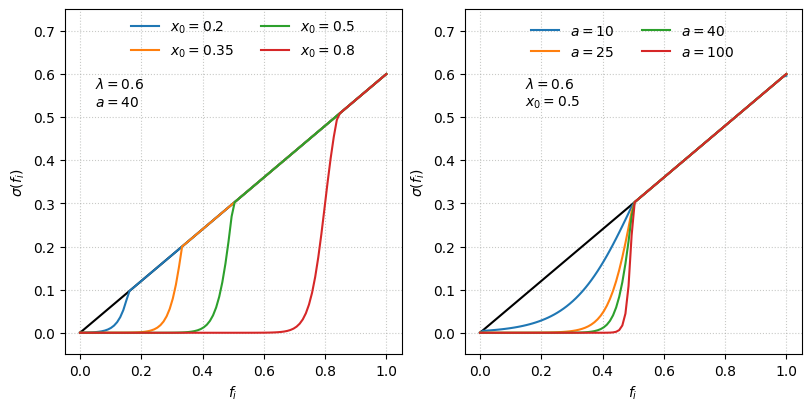

In [113]:
fig, ax = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
ax[0].grid(color='xkcd:gray', ls=':', alpha=0.5)
ax[1].grid(color='xkcd:gray', ls=':', alpha=0.5)

x = np.linspace(0.0,1.0,100)
l = 0.6


#linear c.i.
ax[0].plot(x, l*x, color='k')
ax[1].plot(x, l*x, color='k')

# sigmoid, varying x0
a = 40
ax[0].text(0.09, 0.72, f'$a = {a}$', transform=ax[0].transAxes)
ax[0].text(0.09, 0.77, f'$\lambda = {l}$', transform=ax[0].transAxes)
x0s = [0.2, 0.35, 0.5, 0.8]
for x0 in x0s:
    ci2_args = (x0, a)
    ci2_args = (x0, a, True)
    ax[0].plot(x, [l*ci2(xval, *ci2_args) for xval in x] , label=f'$x_0 = {x0}$')
ax[0].set(ylim=(-0.05, l+0.15), xlabel='$f_i$', ylabel='$\sigma ( f_i )$')
ax[0].legend(frameon=False, loc=(0.18, 0.84), ncol=int(len(x0s)/2))


# sigmoid, varying a
x0 = 0.5
ax[1].text(0.18, 0.72, f'$x_0 = {x0}$', transform=ax[1].transAxes)
ax[1].text(0.18, 0.77, f'$\lambda = {l}$', transform=ax[1].transAxes)
aparams = [10, 25, 40, 100]
for a in aparams:
    ci2_args = (x0, a)
    ci2_args = (x0, a, True)
    ax[1].plot(x, [l*ci2(xval, *ci2_args) for xval in x], label=f'$a= {a}$')
ax[1].set(ylim=(-0.05, l+0.15), xlabel='$f_i$', ylabel='$\sigma ( f_i )$')
ax[1].legend(frameon=False, loc=(0.18, 0.84), ncol=int(len(aparams)/2))

# fig.savefig('cross_inhibition_func_samples.png')
fig.savefig('cross_inhibition_func_samples_cut.png')


## CI nonlinear only when sigma(x) smaller than x

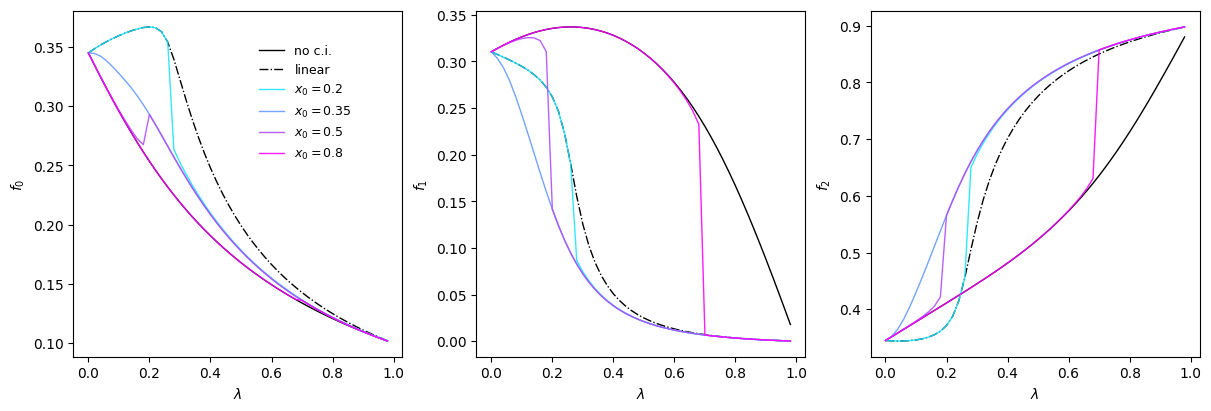

In [119]:
ls = np.arange(0.0, 1.0, 0.02)
pis, qs = [0.1, 0.1], [9.0, 10.0]
fs0 = [1.0, 0.0, 0.0]



fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
for i in range(3):
    ax[i].set(xlabel='$\lambda$', ylabel=f'$f_{i}$')

# no cross inhibition:
fs_evo = [[], [], []]
lci = 0.0
for l in ls:
    fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq)
    for i in range(3):
        fs_evo[i].append(fs[i])
for i in range(3):
    label='no c.i.' if i==0 else '_nolabel_'
    ax[i].plot(ls, fs_evo[i], ls='-', color='k', lw=1.0, label=label)

# cross inhibition = interdependence
fs_evo = [[], [], []]
for l in ls:
    lci = l
    fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq)
    for i in range(3):
        fs_evo[i].append(fs[i])
for i in range(3):
    # label=r"$\lambda' = \lambda$" if i==0 else '_nolabel_'
    label=r"linear" if i==0 else '_nolabel_'
    ax[i].plot(ls, fs_evo[i], ls='-.', color='xkcd:black', lw=1.0, label=label)

# cross inhibition = sigmoid of the inhibiting population
# varying x0:
x0s = [0.2, 0.35, 0.5, 0.8]
colors = plt.cm.cool(np.linspace(0.1,0.99,len(x0s)))
for x0,c in zip(x0s,colors): # threshold of the step function
    fs_evo = [[], [], []]
    ci2_args = (x0, 40, True)
    for l in ls:
        lci = l
        fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci2, ci2_args)
        for i in range(3):
            fs_evo[i].append(fs[i])
    for i in range(3):
        label=rf"$x_0 = {x0}$" if i==0 else '_nolabel_'
        ax[i].plot(ls, fs_evo[i], label=label, lw=1.0, alpha=0.9, color=c)

# varying a instead:
# aparams = [5, 10, 20, 40]
# colors = plt.cm.cool(np.linspace(0.1,0.99,len(aparams)))
# for a,c in zip(aparams,colors): # threshold of the step function
#     fs_evo = [[], [], []]
#     ci2_args = (0.5, a, True)
#     for l in ls:
#         lci = l
#         fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci2, ci2_args)
#         for i in range(3):
#             fs_evo[i].append(fs[i])
#     for i in range(3):
#         label=rf"$a = {a}$" if i==0 else '_nolabel_'
#         ax[i].plot(ls, fs_evo[i], label=label, lw=1.0, alpha=0.9, color=c)

ax[0].legend(loc=(0.55,0.55), fontsize=9, frameon=False)

fig.savefig('ci_numerical_int_compare_lin_and_sigmoids_chx0_CUT.png')
# fig.savefig('ci_numerical_int_compare_lin_and_sigmoids_cha_CUT.png')